In [1]:
from SkyTools import fluxutils
import astropy.units as u
import warnings

warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Convert observed flux to \n restframe luminosity with spectral index SED')

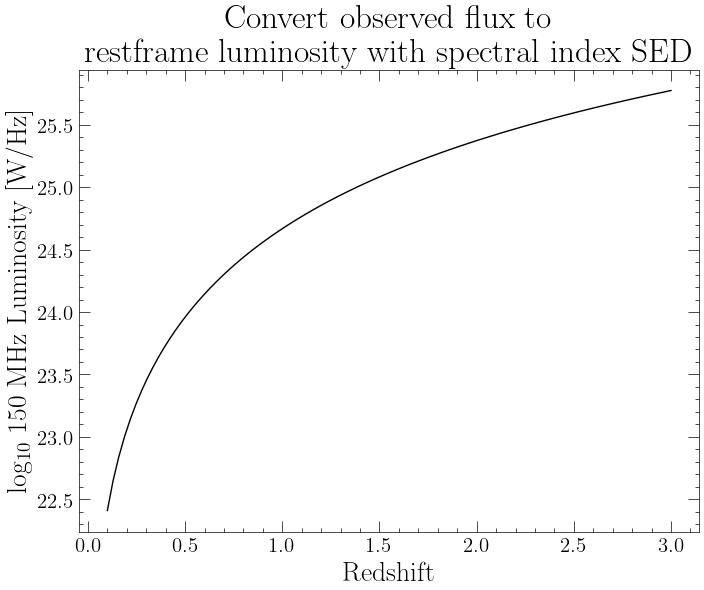

In [2]:
zgrid = np.linspace(0.1, 3, 100)

flux_144 = 1. # mJy
alpha = -0.8 
obs_freq = 144 # MHz
rest_freq = 150 # MHz

lum = fluxutils.luminosity_at_rest_nu(obsflux=flux_144, alpha=alpha, 
                                      nu_obs=obs_freq, nu_rest_want=rest_freq, 
                                      z=zgrid, nu_unit='MHz', flux_unit='mJy', energy=False)

plt.plot(zgrid, np.log10(lum), c='k')
plt.xlabel('Redshift')
plt.ylabel('log$_{10}$ 150 MHz Luminosity [W/Hz]')
plt.title('Convert observed flux to \n restframe luminosity with spectral index SED')

Go backwards
-> Predict observed fluxes from luminosities at varying redshifts, recover input flux

In [3]:
fluxutils.flux_at_obsnu_from_rest_lum(lum, -0.8, 150, 144, zgrid, nu_unit='MHz', outflux_unit='mJy', energy=False)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Sensitivity of radio surveys to star formation

Text(0.5, 1.0, 'Radio luminosity - SFR calibrations \n FIRST vs. LoTSS sensitivity')

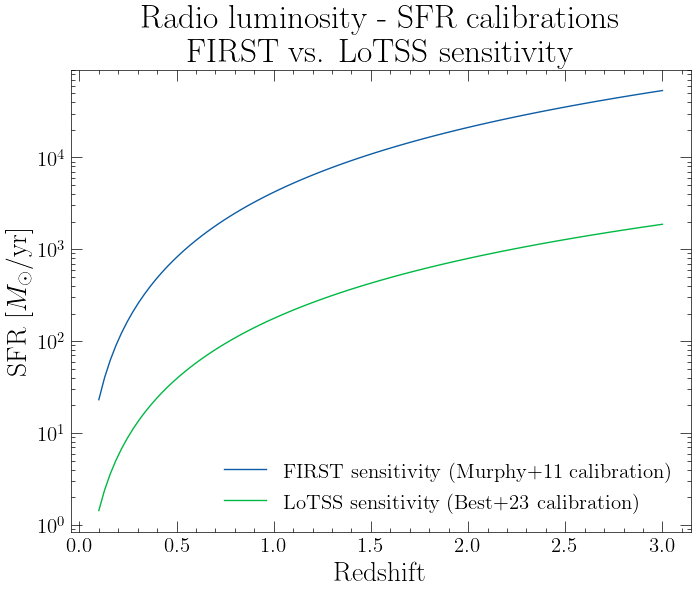

In [4]:
first_sfr = fluxutils.radio_sfr_murphy(1., -0.8, 1.4, 1.4, zgrid, flux_unit='mJy')
lotss_sfr = fluxutils.radio_sfr_best(1., -0.8, 144, zgrid, flux_unit='mJy')
plt.plot(zgrid, first_sfr, label='FIRST sensitivity (Murphy+11 calibration)')
plt.plot(zgrid, lotss_sfr, label='LoTSS sensitivity (Best+23 calibration)')
plt.yscale('log')
plt.xlabel('Redshift')
plt.ylabel(r'SFR [$M_{\odot}$/yr]')
plt.legend(fontsize=15)
plt.title('Radio luminosity - SFR calibrations \n FIRST vs. LoTSS sensitivity')

Text(0.5, 1.0, 'Quasar spectrum in $f_{\\lambda}$ units')

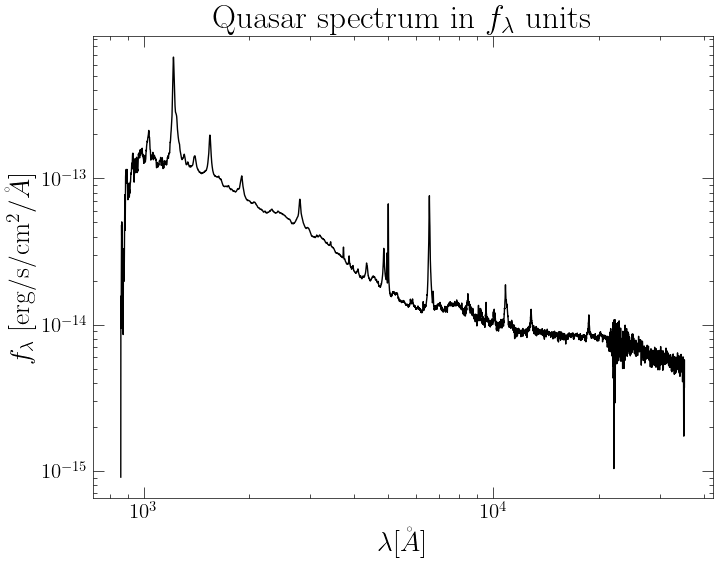

In [5]:

qspec = Table.read('optical_nir_qso_sed_001.fits')
lam, flam = qspec['WAVELENGTH'], qspec['FLUX']
lam_unit = 'AA'
fl_unit = 'erg/s/cm^2/AA'
plt.loglog(lam, flam, c='k')
plt.ylabel(r'$f_{\lambda}$ [erg/s/cm$^2 / \AA$]')
plt.xlabel(r'$\lambda [\AA]$')
plt.title('Quasar spectrum in $f_{\lambda}$ units')

Text(0.5, 1.0, 'Convert to $f_{\\nu}$ units')

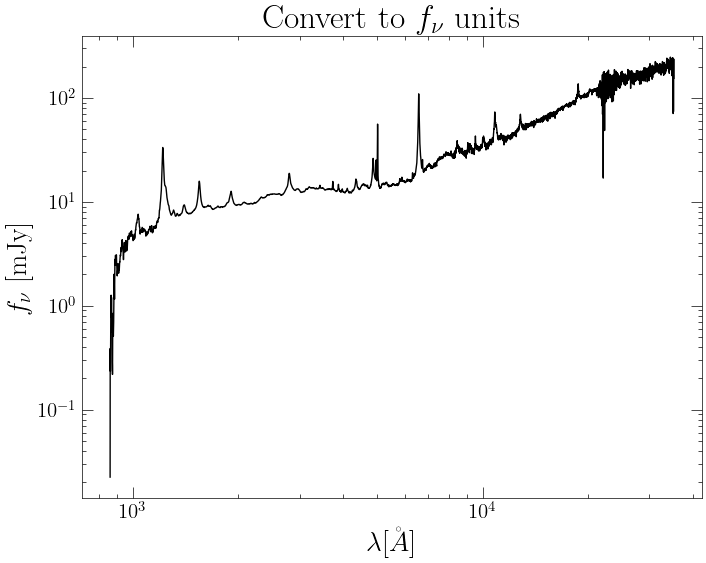

In [6]:
fnu = fluxutils.convert_spectral_flux((lam, flam), 
                             nu_or_lam_unit=lam_unit, fluxunit=fl_unit, 
                             output_unit='mJy')
plt.loglog(lam, fnu, c='k')
plt.ylabel(r'$f_{\nu}$ [mJy]')
plt.xlabel(r'$\lambda [\AA]$')
plt.title(r'Convert to $f_{\nu}$ units')

Text(0.5, 1.0, 'Convert flux densities to fluxes')

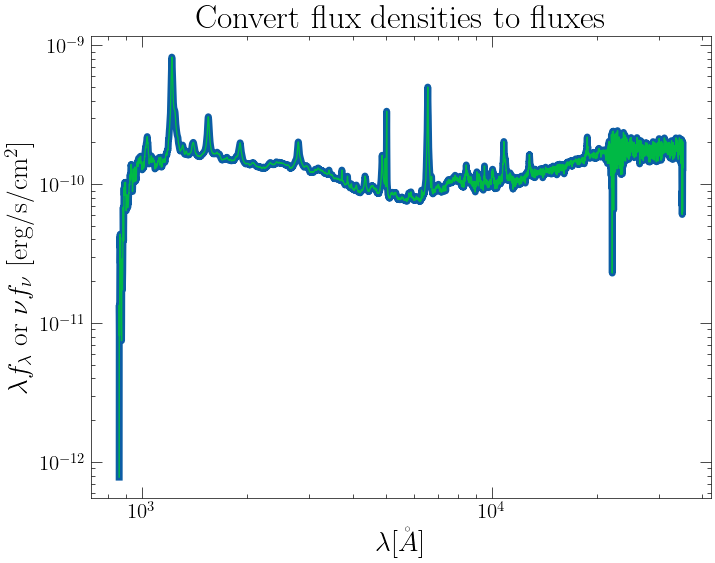

In [7]:
enu = fluxutils.flux_density_2_flux((lam, fnu), fluxunit='mJy', nu_or_lam_unit='AA')
elam = fluxutils.flux_density_2_flux((lam, flam), fluxunit='erg/s/cm^2/AA', nu_or_lam_unit='AA')


plt.loglog(lam, elam, linewidth=5)
plt.loglog(lam, enu)
plt.ylabel(r'$\lambda f_{\lambda}$ or $ \nu f_{\nu}$ [erg/s/cm$^2$]')
plt.xlabel(r'$\lambda [\AA]$')
plt.title('Convert flux densities to fluxes')

Text(0.5, 1.0, 'Rayleigh-Jeans spectrum \n plus extrapolation assuming Rayleigh-Jeans')

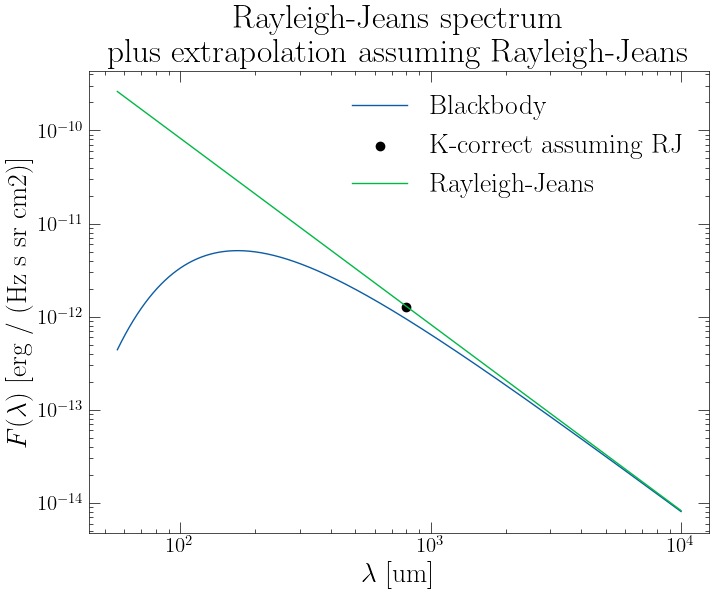

In [8]:
from astropy.modeling.models import BlackBody
wavelengths = np.logspace(1.75, 4, num=1000) * u.um
# blackbody parameters
temperature = 30 * u.K

# BlackBody provides the results in ergs/(cm^2 Hz s sr) when scale has no units
bb_result = BlackBody(temperature=temperature)(wavelengths)

plt.loglog(wavelengths, bb_result, '-', label='Blackbody')
plt.xlabel(fr"$\lambda$ [{wavelengths.unit}]")
plt.ylabel(fr"$F(\lambda)$ [{bb_result.unit}]")

extrap_l = 800 # micron
extrap_f = fluxutils.extrap_flux_rayleigh_jeans(bb_result[-1].value, 
                                                wavelengths[-1].value, extrap_l, 
                                                frequencies=False)
plt.scatter([extrap_l], [extrap_f], c='k', label='K-correct assuming RJ')
plt.plot(wavelengths, 
         fluxutils.rayleigh_jeans(wavelengths.value, 
                                  temperature.value, 
                                  output_unit='erg/s/sr/cm^2/Hz'),
        label='Rayleigh-Jeans')
plt.legend()
plt.title('Rayleigh-Jeans spectrum \n plus extrapolation assuming Rayleigh-Jeans')

Text(0.5, 1.0, 'Predict observed quasar color as function of redshift')

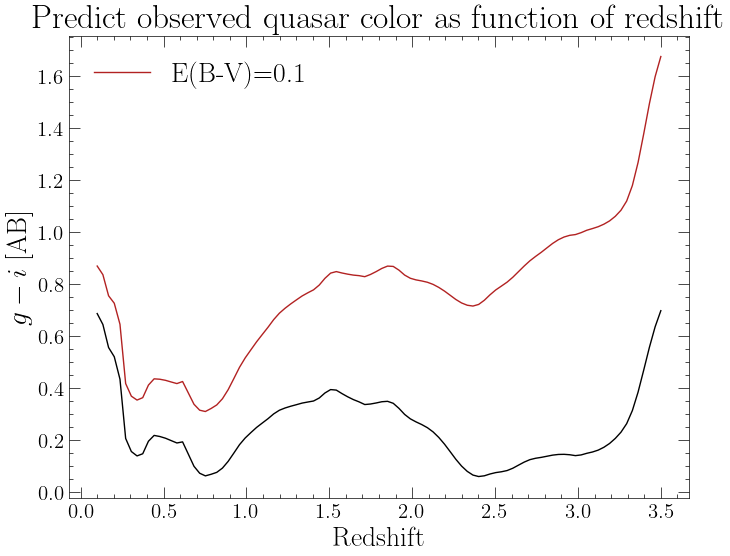

In [12]:
g_i = []
for z in np.linspace(0.1, 3.5, 100):
    g_i.append(fluxutils.syn_color((lam, flam), 'g', 'i', 'erg/s/cm^2/AA', 'AA', z))
    
newlam, extf = fluxutils.extinct_spec((lam, flam), 'AA', 0.1)

gi_red = []
for z in np.linspace(0.1, 3.5, 100):
    gi_red.append(fluxutils.syn_color((newlam, extf), 'g', 'i', 'erg/s/cm^2/AA', 'AA', z))
    
plt.plot(np.linspace(0.1, 3.5, 100), g_i, c='k')
plt.plot(np.linspace(0.1, 3.5, 100), gi_red, c='firebrick', label='E(B-V)=0.1')
plt.ylabel('$g-i$ [AB]')
plt.xlabel('Redshift')
plt.legend()
plt.title('Predict observed quasar color as function of redshift')

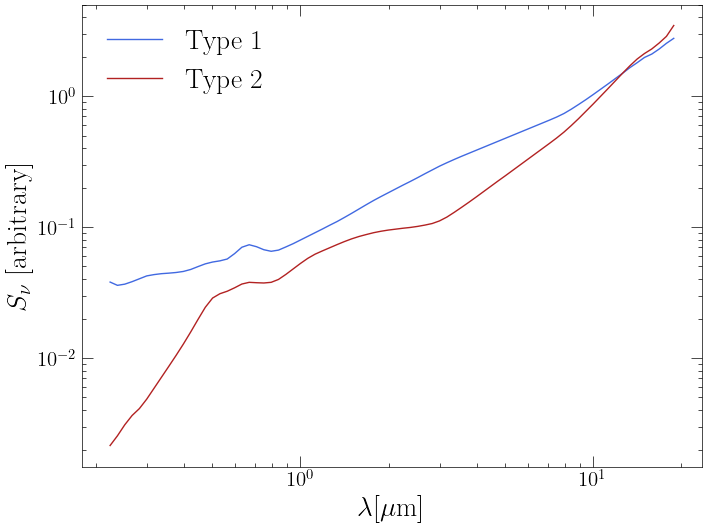

In [13]:
from SkyTools import fluxutils
qsed = Table.read('/home/graysonpetter/ssd/Dartmouth/data/templates/hickox17/hickox_17_agn_sed.fits')
plt.loglog(10**qsed['logWave'], 10**qsed['logSED1'], c='royalblue', label='Type 1')
plt.loglog(10**qsed['logWave'], 10**qsed['logSED2'], c='firebrick', label='Type 2')
plt.ylabel(r'$S_{\nu}$ [arbitrary]')
plt.xlabel(r'$\lambda [\mu$m]')
plt.legend()


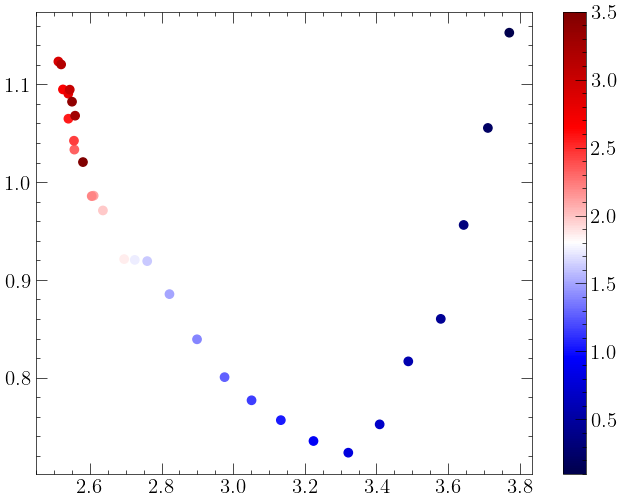

In [16]:
zs = np.linspace(0.1, 3.5, 30)
w12, w23 = [], []
for z in zs:
    w12.append(fluxutils.syn_color((10**qsed['logWave'], 10**qsed['logSED2']), 'W1', 'W2', 'mJy', 'um', z, vega=True))
    w23.append(fluxutils.syn_color((10**qsed['logWave'], 10**qsed['logSED2']), 'W2', 'W3', 'mJy', 'um', z, vega=True))
    
plt.scatter(w23, w12, c=zs, cmap='seismic')
plt.colorbar()
#plt.plot(np.linspace(0.1, 3.5, 50), w12)

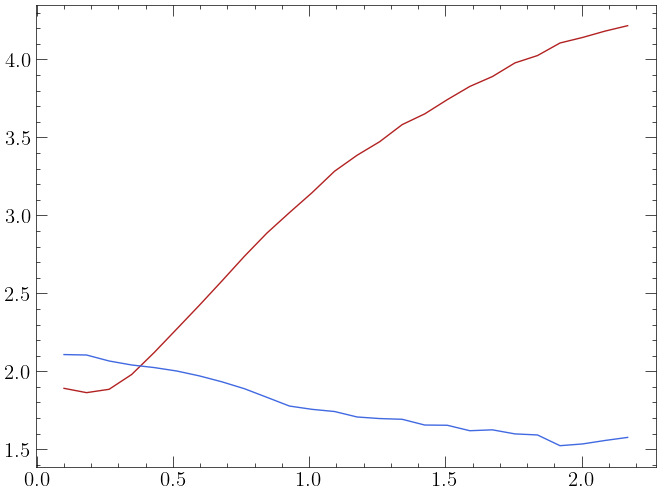

In [19]:
zs = np.linspace(0.1, 2.5, 30)
obsrw, unrw = [], []
for z in zs:
    obsrw.append(fluxutils.syn_color((10**qsed['logWave'], 10**qsed['logSED2']), 'r', 'W2', 'mJy', 'um', z, vega=False))
    unrw.append(fluxutils.syn_color((10**qsed['logWave'], 10**qsed['logSED1']), 'r', 'W2', 'mJy', 'um', z, vega=False))
    
plt.plot(zs, obsrw, c='firebrick')
plt.plot(zs, unrw, c='royalblue')


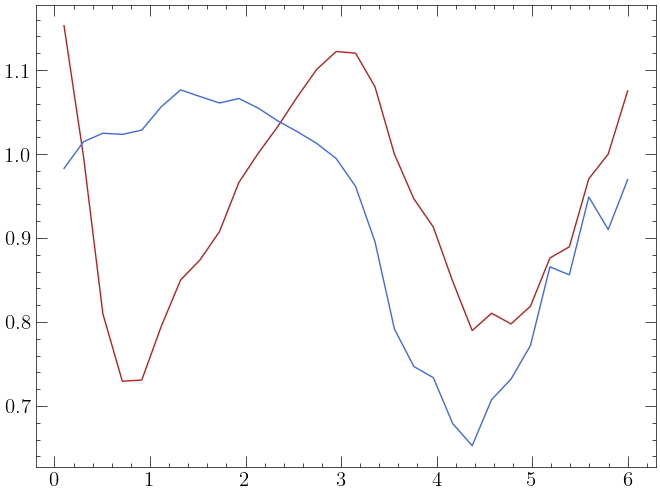

In [25]:
zs = np.linspace(0.1, 6, 30)
w12obs, w12un = [], []
for z in zs:
    w12obs.append(fluxutils.syn_color(10**qsed['logSED2'], 10**qsed['logWave'], 'W1', 'W2', 'mJy', 'um', z, vega=True))
    w12un.append(fluxutils.syn_color(10**qsed['logSED1'], 10**qsed['logWave'], 'W1', 'W2', 'mJy', 'um', z, vega=True))
plt.plot(zs, w12obs, c='firebrick')
plt.plot(zs, w12un, c='royalblue')